# Symmetric Mean Absolute Percentage Error (SMAPE)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')


In [4]:
# Función SMAPE
def smape(y_true, y_pred, epsilon=1e-8):
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator = np.where(denominator == 0, epsilon, denominator)
    return np.mean(2 * np.abs(y_true - y_pred) / denominator) * 100

# Función MAPE
def mape(y_true, y_pred, epsilon=1e-8):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon))) * 100


In [6]:
np.random.seed(42)
n_days = 30
hours_per_day = 24
n_samples = n_days * hours_per_day

# Timestamps
start_date = datetime(2024, 1, 1)
timestamps = [start_date + timedelta(hours=i) for i in range(n_samples)]

# Características temporales
hours = np.array([t.hour for t in timestamps])
days_of_week = np.array([t.weekday() for t in timestamps])
is_weekend = (days_of_week >= 5).astype(int)


In [8]:
# Demanda base
base_demand = 150 + 100 * np.sin(2 * np.pi * hours / 24 - np.pi/2)
weekend_effect = is_weekend * (-20)
random_variation = np.random.normal(0, 15, n_samples)
temperature_effect = np.random.normal(0, 25, n_samples)

# Demanda final
demand = np.maximum(base_demand + weekend_effect + random_variation + temperature_effect, 20)

# DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'hour': hours,
    'day_of_week': days_of_week,
    'is_weekend': is_weekend,
    'demand': demand
})

# Características cíclicas
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print("Estadísticas de la demanda eléctrica:")
print(df['demand'].describe())


Estadísticas de la demanda eléctrica:
count    720.000000
mean     147.390126
std       75.862951
min       20.000000
25%       79.691518
50%      147.668082
75%      212.482719
max      317.631481
Name: demand, dtype: float64


In [10]:
features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']
X = df[features]
y = df['demand']

split_idx = int(0.8 * len(df))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nDatos de entrenamiento: {len(X_train)} muestras")
print(f"Datos de prueba: {len(X_test)} muestras")



Datos de entrenamiento: 576 muestras
Datos de prueba: 144 muestras


In [12]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_score = mape(y_test, y_pred_test)
    smape_score = smape(y_test, y_pred_test)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape_score,
        'SMAPE': smape_score,
        'train_pred': y_pred_train,
        'test_pred': y_pred_test
    }
    
    print(f"\n{name} - Métricas en conjunto de prueba:")
    print(f"  MAE: {mae:.2f} MW")
    print(f"  RMSE: {rmse:.2f} MW")
    print(f"  MAPE: {mape_score:.2f}%")
    print(f"  SMAPE: {smape_score:.2f}%")



Linear Regression - Métricas en conjunto de prueba:
  MAE: 22.67 MW
  RMSE: 28.85 MW
  MAPE: 24.87%
  SMAPE: 21.60%

Random Forest - Métricas en conjunto de prueba:
  MAE: 24.90 MW
  RMSE: 31.82 MW
  MAPE: 27.43%
  SMAPE: 23.66%


In [14]:
print("\n" + "="*60)
print("DEMOSTRACIÓN DE SIMETRÍA: SMAPE vs MAPE")
print("="*60)

test_cases = [
    {'real': 100, 'pred1': 120, 'pred2': 80, 'desc': 'Error ±20% en valor 100'},
    {'real': 50, 'pred1': 75, 'pred2': 25, 'desc': 'Error ±50% en valor 50'},
    {'real': 200, 'pred1': 300, 'pred2': 100, 'desc': 'Error ±50% en valor 200'},
]

for case in test_cases:
    real = np.array([case['real'], case['real']])
    pred_over = np.array([case['pred1'], case['real']])
    pred_under = np.array([case['real'], case['pred2']])
    
    mape_over = mape(real, pred_over)
    mape_under = mape(real, pred_under)
    smape_over = smape(real, pred_over)
    smape_under = smape(real, pred_under)
    
    print(f"\n{case['desc']}:")
    print(f"  MAPE - Sobreestimación: {mape_over:.2f}%, Subestimación: {mape_under:.2f}%")
    print(f"  SMAPE - Sobreestimación: {smape_over:.2f}%, Subestimación: {smape_under:.2f}%")



DEMOSTRACIÓN DE SIMETRÍA: SMAPE vs MAPE

Error ±20% en valor 100:
  MAPE - Sobreestimación: 10.00%, Subestimación: 10.00%
  SMAPE - Sobreestimación: 9.09%, Subestimación: 11.11%

Error ±50% en valor 50:
  MAPE - Sobreestimación: 25.00%, Subestimación: 25.00%
  SMAPE - Sobreestimación: 20.00%, Subestimación: 33.33%

Error ±50% en valor 200:
  MAPE - Sobreestimación: 25.00%, Subestimación: 25.00%
  SMAPE - Sobreestimación: 20.00%, Subestimación: 33.33%


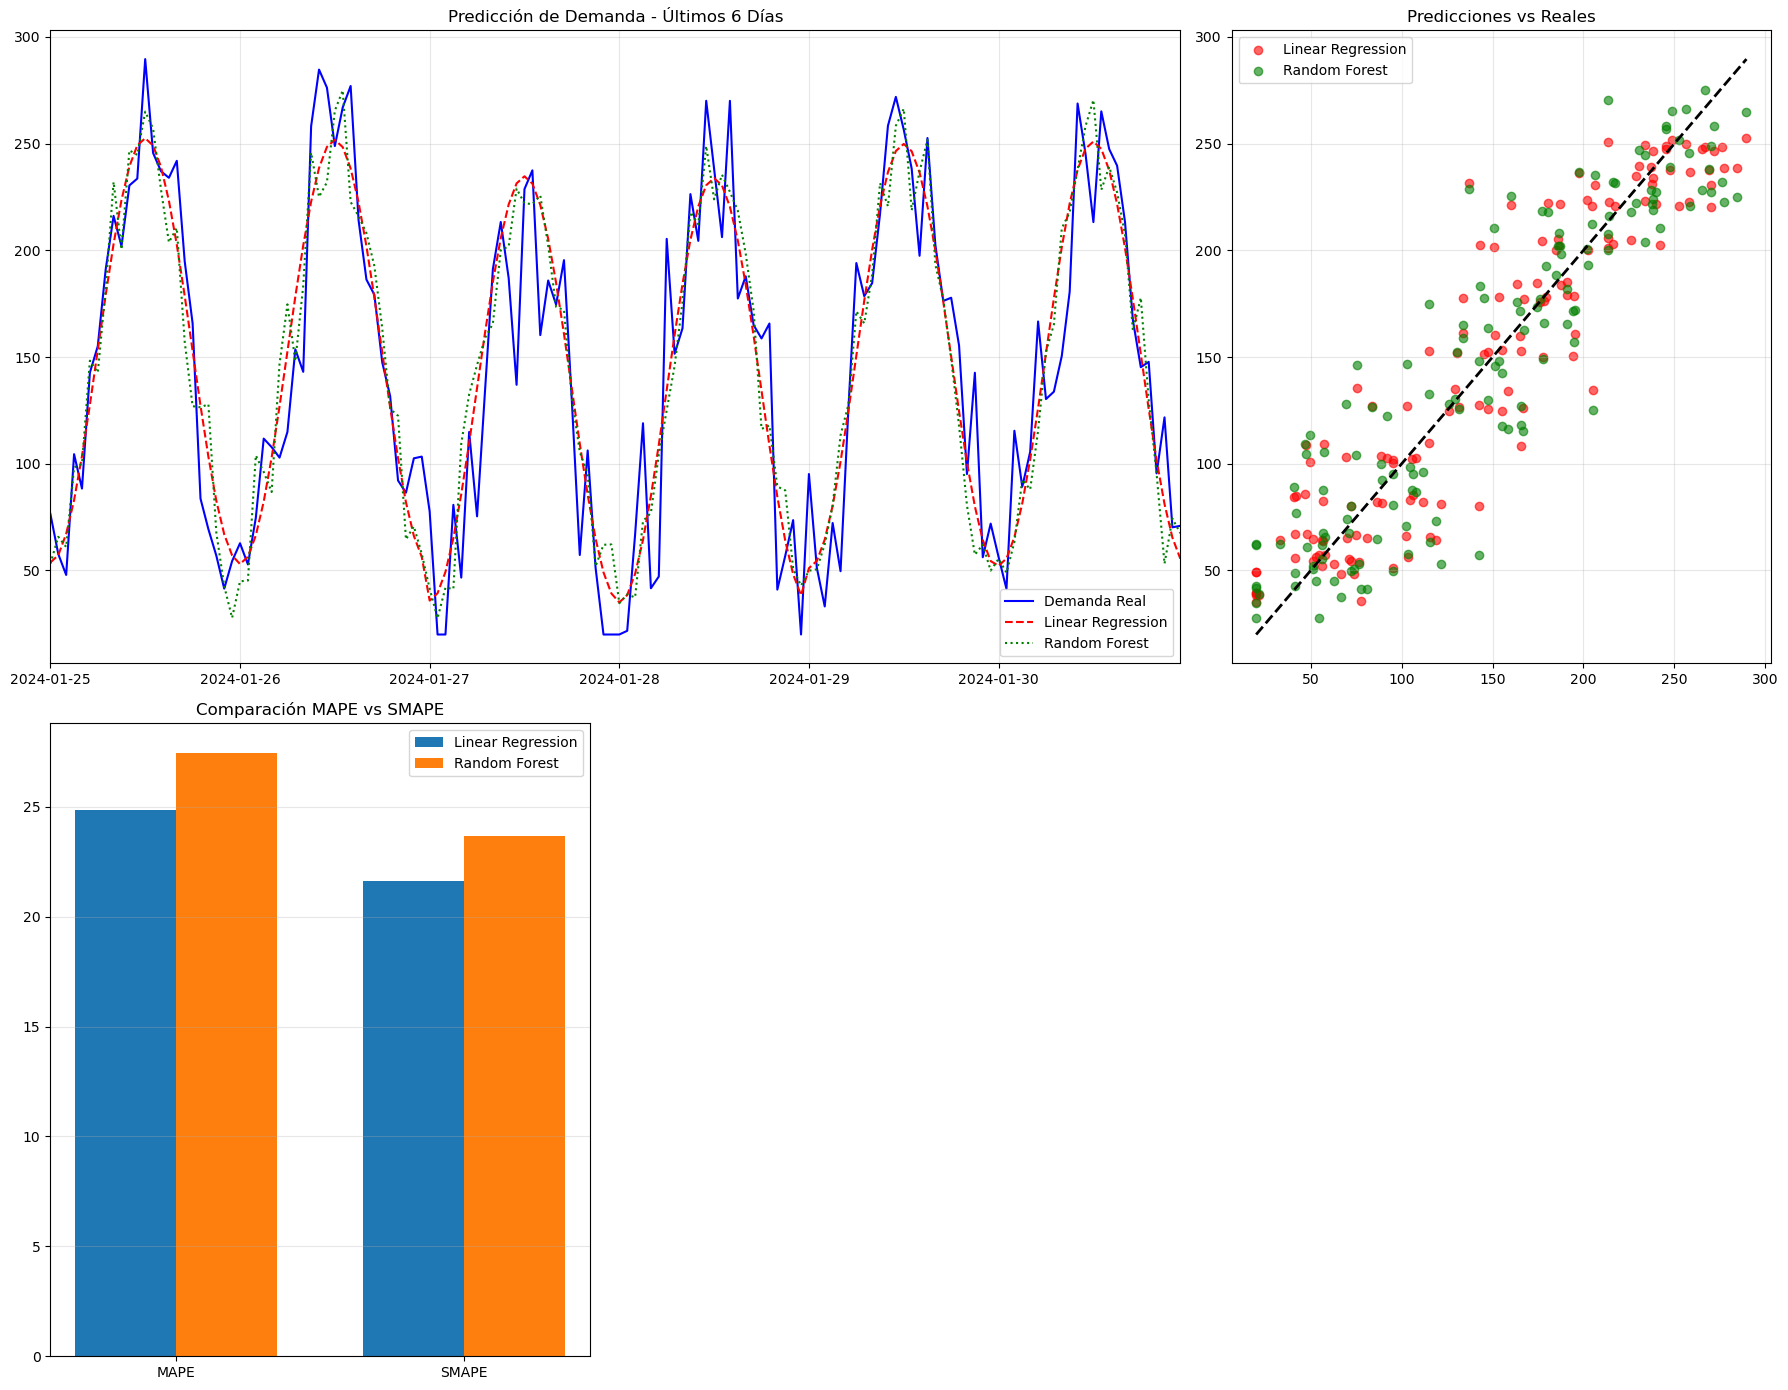

In [16]:
fig = plt.figure(figsize=(18, 14))

# Serie temporal
ax1 = plt.subplot(2, 3, (1, 2))
test_timestamps = df['timestamp'][split_idx:].values
ax1.plot(test_timestamps, y_test.values, 'b-', label='Demanda Real')
ax1.plot(test_timestamps, results['Linear Regression']['test_pred'], 'r--', label='Linear Regression')
ax1.plot(test_timestamps, results['Random Forest']['test_pred'], 'g:', label='Random Forest')
ax1.set_xlim(test_timestamps[-144], test_timestamps[-1])
ax1.set_title('Predicción de Demanda - Últimos 6 Días')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter pred vs real
ax2 = plt.subplot(2, 3, 3)
colors = ['red', 'green']
for i, name in enumerate(models.keys()):
    ax2.scatter(y_test, results[name]['test_pred'], alpha=0.6, color=colors[i], label=name)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax2.set_title('Predicciones vs Reales')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Barras MAPE vs SMAPE
ax3 = plt.subplot(2, 3, 4)
metrics = ['MAPE', 'SMAPE']
x_pos = np.arange(len(metrics))
width = 0.35
for i, name in enumerate(models.keys()):
    values = [results[name][m] for m in metrics]
    ax3.bar(x_pos + i*width - width/2, values, width, label=name)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics)
ax3.set_title('Comparación MAPE vs SMAPE')
ax3.legend()
ax3.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


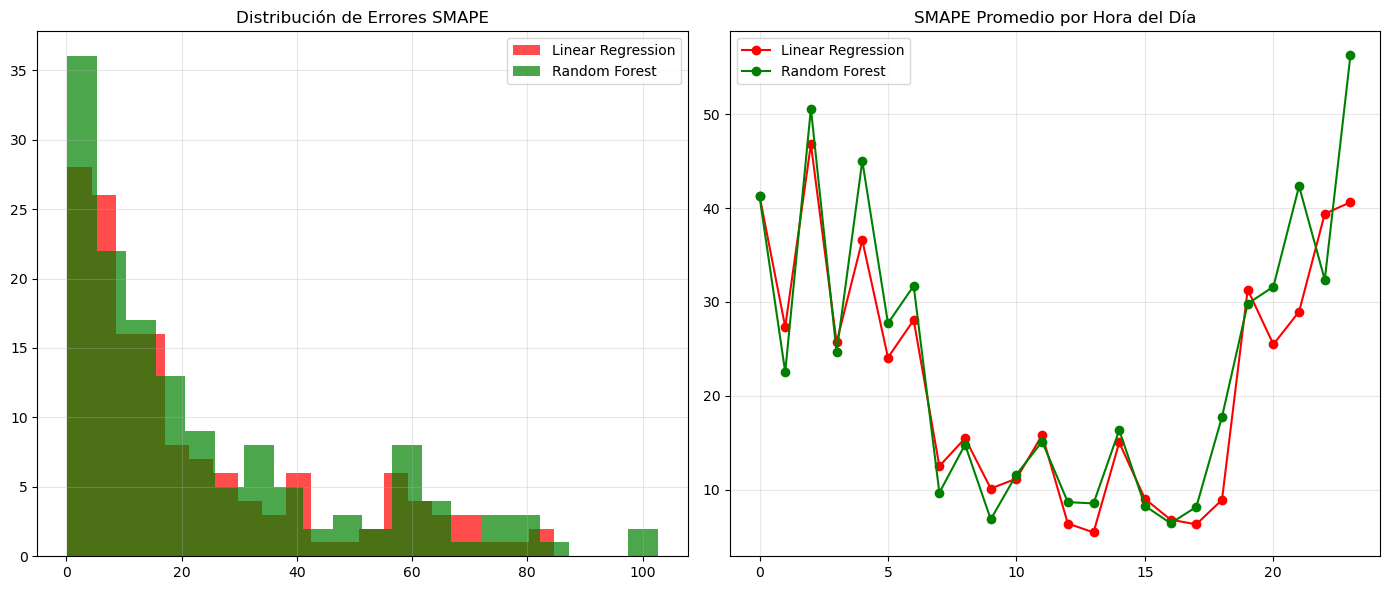

In [18]:
fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(14, 6))

# Distribución SMAPE
for name, color in zip(models.keys(), ['red', 'green']):
    y_pred = results[name]['test_pred']
    smape_values = 2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred)) * 100
    ax4.hist(smape_values, bins=20, alpha=0.7, label=f'{name}', color=color)
ax4.set_title('Distribución de Errores SMAPE')
ax4.legend()
ax4.grid(True, alpha=0.3)

# SMAPE por hora
test_hours = df['hour'][split_idx:].values
for name, color in zip(models.keys(), ['red', 'green']):
    y_pred = results[name]['test_pred']
    smape_hour = []
    for hour in sorted(set(test_hours)):
        mask = test_hours == hour
        smape_hour.append(np.mean(2 * np.abs(y_test[mask] - y_pred[mask]) / 
                                  (np.abs(y_test[mask]) + np.abs(y_pred[mask])) * 100))
    ax5.plot(sorted(set(test_hours)), smape_hour, marker='o', label=name, color=color)
ax5.set_title('SMAPE Promedio por Hora del Día')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
print("\n" + "="*60)
print("ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

for name in models.keys():
    y_pred = results[name]['test_pred']
    smape_vals = 2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred)) * 100
    print(f"\n{name}:")
    print(f"  Media: {np.mean(smape_vals):.2f}%")
    print(f"  Mediana: {np.median(smape_vals):.2f}%")
    print(f"  SMAPE < 10%: {(np.sum(smape_vals < 10)/len(smape_vals)*100):.1f}%")



ANÁLISIS ESTADÍSTICO DETALLADO

Linear Regression:
  Media: 21.60%
  Mediana: 13.60%
  SMAPE < 10%: 41.0%

Random Forest:
  Media: 23.66%
  Mediana: 14.60%
  SMAPE < 10%: 39.6%


In [22]:
extreme_cases = [
    {'y_true': 100, 'y_pred': 0, 'desc': 'Predicción cero'},
    {'y_true': 0, 'y_pred': 100, 'desc': 'Valor real cero'},
    {'y_true': 5, 'y_pred': 10, 'desc': 'Valores pequeños'},
    {'y_true': 1000, 'y_pred': 2000, 'desc': 'Valores grandes'},
]

for case in extreme_cases:
    y_true_case = np.array([case['y_true']])
    y_pred_case = np.array([case['y_pred']])
    print(f"\n{case['desc']}:")
    print(f"  MAPE: {mape(y_true_case, y_pred_case):.2f}%, SMAPE: {smape(y_true_case, y_pred_case):.2f}%")



Predicción cero:
  MAPE: 100.00%, SMAPE: 200.00%

Valor real cero:
  MAPE: 1000000000000.00%, SMAPE: 200.00%

Valores pequeños:
  MAPE: 100.00%, SMAPE: 66.67%

Valores grandes:
  MAPE: 100.00%, SMAPE: 66.67%


In [30]:
class SMAPECalculator:
    """
    Calculadora robusta de SMAPE con variantes avanzadas.
    Incluye:
    - SMAPE estándar
    - SMAPE con intervalo de confianza (bootstrap)
    """

    @staticmethod
    def standard_smape(y_true, y_pred, epsilon=1e-8):
        """
        Calcula SMAPE estándar, evitando divisiones por cero.
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)

        denom = np.abs(y_true) + np.abs(y_pred)
        denom = np.where(denom < epsilon, epsilon, denom)

        return np.mean(2 * np.abs(y_true - y_pred) / denom) * 100

    @staticmethod
    def smape_with_confidence_interval(y_true, y_pred, confidence=0.95):
        """
        Calcula SMAPE con intervalo de confianza mediante bootstrap.
        Corrige el error de indexación de pandas.Series convirtiendo a numpy arrays.
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)

        n_bootstrap = 500
        smape_bootstrap = []

        for _ in range(n_bootstrap):
            indices = np.random.choice(len(y_true), len(y_true), replace=True)
            smape_boot = SMAPECalculator.standard_smape(y_true[indices], y_pred[indices])
            smape_bootstrap.append(smape_boot)

        mean = np.mean(smape_bootstrap)
        ci_lower, ci_upper = np.percentile(smape_bootstrap, [2.5, 97.5])
        return mean, (ci_lower, ci_upper)


# === Uso de la clase ===
calculator = SMAPECalculator()

best_model = 'Random Forest'
y_pred_best = results[best_model]['test_pred']

smape_std = calculator.standard_smape(y_test, y_pred_best)
smape_mean, (ci_lower, ci_upper) = calculator.smape_with_confidence_interval(y_test, y_pred_best)

print(f"\nSMAPE estándar: {smape_std:.2f}%")
print(f"SMAPE con IC 95%: {smape_mean:.2f}% [{ci_lower:.2f}%, {ci_upper:.2f}%]")



SMAPE estándar: 23.66%
SMAPE con IC 95%: 23.49% [19.47%, 27.84%]
